# ADAM Converging issues

This notebook puts into evidence that the ADAM algorithms fails to reach convergence in some specific cases.

For Adam algorithm: https://arxiv.org/abs/1412.6980

In [1]:
# imports

%matplotlib notebook
from matplotlib import pyplot as plt

import jax
from jax import numpy as jnp
from jax import jit, vmap
import optax

### Let's define a function whose derivative is not an exact 0 at minimum

In [2]:
f = lambda x: jnp.sin(x)
print (f(jnp.pi))

@vmap
def gradf(x): 
    return jax.grad(f)(x)

-8.742278e-08


<IPython.core.display.Javascript object>


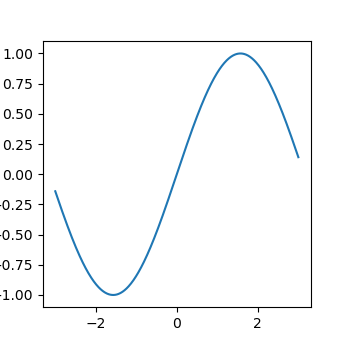

In [3]:
# nice sinusoid, isn't it ?
plt.figure(figsize=(3,3))
x=jnp.linspace(-3,3,601)
plt.plot(x,f(x))

### Let's use Adam to find this minimum

In [4]:
# note : choice of learning_rate is to showcase the issue. Usually lower values are employed
# you'll find below an example of non-convergence with a more usual value
optimizer = optax.adam(learning_rate=10)
b1 = 0.9
b2 = 0.999

def rescale(b,incr):
    return (1-b**(incr))

In [5]:
def seek_minimum(nloop, current_x,opt_state):
    history={}
    
    history['x']=list()
    history['state']=list()
    
    @jit
    def update(current_x,opt_state):
        value,grad=jax.value_and_grad(f)(current_x)
        updates, opt_state = optimizer.update(grad, opt_state,current_x)
        
        return updates,opt_state
    
    for i in range (nloop):
        updates,opt_state = update(current_x,opt_state)

        history['x'].append(current_x)
        history['state'].append(opt_state)
        
        current_x = current_x + updates
   
    return history



In [6]:
# initialization
current_x=0.
opt_state=optimizer.init(current_x)

In [7]:
history = seek_minimum(1000,current_x,opt_state)

<IPython.core.display.Javascript object>


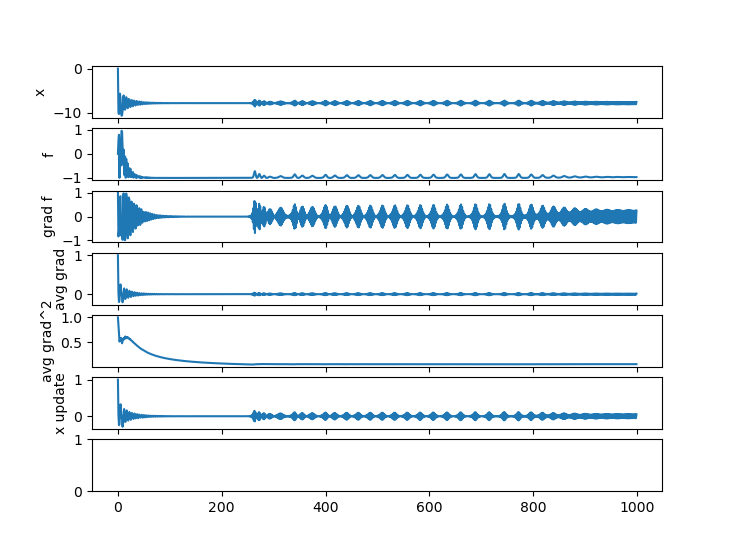

Text(0, 0.5, 'x update')

In [8]:
count_array=jnp.array([s[0].count for s in history['state']])
# note that here mu and nu are presented debiassed
mu_array=jnp.array([s[0].mu for s in history['state']]) / (1-b1**count_array)
nu_array=jnp.array([s[0].nu for s in history['state']]) / (1-b2**count_array)
x_array = jnp.array(history['x'])

fig,axes = plt.subplots(7, 1,sharex=True)

axes[0].plot(history['x'])
axes[0].set_ylabel('x')

axes[1].plot(f(x_array)) 
axes[1].set_ylabel('f')

axes[2].plot(gradf(x_array) )
axes[2].set_ylabel('grad f')

axes[3].plot(mu_array)
axes[3].set_ylabel('avg grad')

axes[4].plot(nu_array)
axes[4].set_ylabel('avg grad^2')

axes[5].plot(mu_array/jnp.sqrt(nu_array) )
axes[5].set_ylabel('x update')


What is happening ? 

After a burning-in where convergence starts naturally, the averaged 2nd moments converge eventually to 0.
Then, they become sizable with respect to the averaged gradients, leading to a step out of the converged zone.

This issue will only show up
- if the gradient is not an exact 0 at minimum
- if all batches converge to an unique minimum (else the stochasticity will protect the converged value)

In [9]:
# example values at last iteration
jax.grad(f)(x_array[-1]),mu_array[-1],nu_array[-1],(mu_array/jnp.sqrt(nu_array)) [-1]

(DeviceArray(0.25796556, dtype=float32),
 DeviceArray(0.01366221, dtype=float32),
 DeviceArray(0.06763098, dtype=float32),
 DeviceArray(0.05253492, dtype=float32))

### This is not just due to the very large learning rate

In [10]:
# here you may play with any value you like. 
learning_rate=1.e-4
optimizer = optax.adam(learning_rate=learning_rate)

# initialization
current_x=-jnp.pi/2

opt_state=optimizer.init(current_x)
#opt_state[0].nu,opt_state[0].mu
history = seek_minimum(2000,current_x,opt_state)

<IPython.core.display.Javascript object>


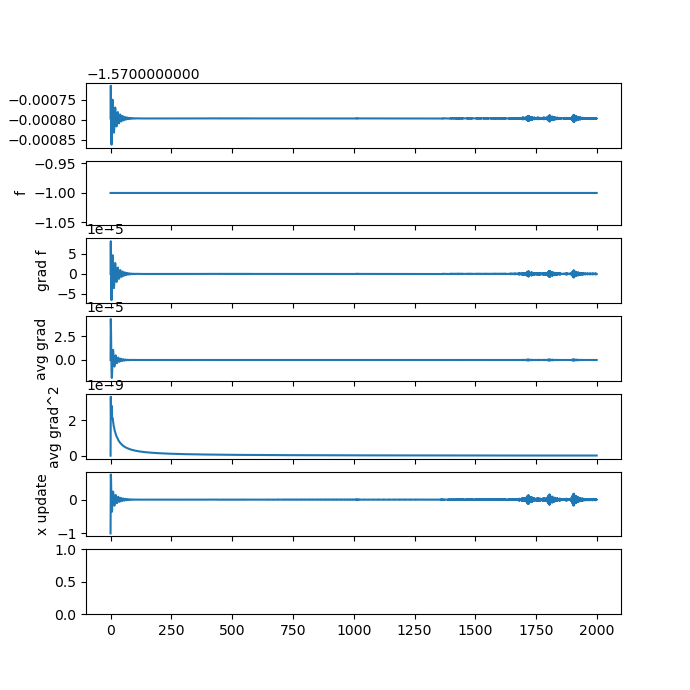

Text(0, 0.5, 'x update')

In [11]:
count_array=jnp.array([s[0].count for s in history['state']])
# note that here mu and nu are presented debiassed
mu_array=jnp.array([s[0].mu for s in history['state']]) / (1-b1**count_array)
nu_array=jnp.array([s[0].nu for s in history['state']]) / (1-b2**count_array)
x_array = jnp.array(history['x'])

fig,axes = plt.subplots(7, 1,sharex=True,figsize=(6,6))

axes[0].plot(history['x'])
axes[0].set_ylabel('x')

axes[1].plot(f(x_array)) 
axes[1].set_ylabel('f')

axes[2].plot(gradf(x_array) )
axes[2].set_ylabel('grad f')

axes[3].plot(mu_array)
axes[3].set_ylabel('avg grad')

axes[4].plot(nu_array)
axes[4].set_ylabel('avg grad^2')

axes[5].plot(mu_array/jnp.sqrt(nu_array) )
axes[5].set_ylabel('x update')
axes[5].set_ylabel('x update')

